## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import glob
import matplotlib as plt
from collections import OrderedDict
import random

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
from sklearn.model_selection import train_test_split


from Utils import *

## Subject 1 Data and Events Loading 

In [2]:
load_data,load_labels = load_data(subject_count=6)

Subject 6: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


In [3]:
for i in range(len(load_labels)):
    df_copy = load_labels[i].copy()
    df_copy['sum'] = df_copy.sum(axis=1)
    df_copy = df_copy[df_copy['sum'] <= 1]
    df_copy = df_copy.drop(columns=['sum'])
    load_labels[i] = df_copy


In [4]:
start_end = []
for data in load_labels:
    start_end_ = start_end_data_finder(data)
    start_end.append(start_end_)

In [5]:
all_extracted_data = []
for i in range(len(start_end)):
    extracted_data = data_extractor(start_end[i],load_data[i])
    all_extracted_data.append(extracted_data)

In [6]:
class_data = {}

for class_idx in range(6):
    class_data[class_idx] = []

for id, sublist in enumerate(all_extracted_data):
    for idx, secondary_list in enumerate(sublist):
        class_data[idx].append(len(secondary_list))

for class_idx, lengths in class_data.items():
    total_length = sum(lengths)
    print(f"Class {class_idx}: Data points = {total_length}")


Class 0: Data points = 1560
Class 1: Data points = 1560
Class 2: Data points = 986
Class 3: Data points = 1558
Class 4: Data points = 1557
Class 5: Data points = 1557


In [35]:
def data_extractor_noevent2(data_list, event_list, number_of_consecutive_rows):
    """
    Extracts random sets of consecutive rows with no events
    from the data and returns them as a NumPy array.

    Args:
        data_list (list of pd.DataFrame): List of DataFrames containing data.
        event_list (list of pd.DataFrame): List of DataFrames containing events.
        number_of_consecutive_rows (int): Number of consecutive rows to extract.

    Returns:
        np.ndarray: NumPy array containing the extracted rows.
    """
    events_rows = []
    for data, event in zip(data_list, event_list):
        indexes = random_indexes_noevent2(event_list)
        for i in range(number_of_consecutive_rows):
            randy = random.choice(indexes)
            events_rows.append(np.array(data_list.iloc[randy:randy+150]))
    events_rows = np.array(events_rows)
    return events_rows

In [36]:
def random_indexes_noevent2(event:pd.DataFrame):
    """
    Generates random row indexes with no events occurring 
    and returns them as a list.
    
    """
    indexes = []
    for i in range(1500):
        rand = random.choice(range(1500))
        num = np.sum(event.loc[rand:rand+149].sum(axis = 1))
        if num == 0:
            indexes.append(rand)
    return indexes

In [37]:
num = np.sum(load_labels[0].loc[10:10+149].sum(axis = 1))
num

0

In [38]:
no_events_data_extracted = []
for idx,subj_data in enumerate(load_data):
    no_event = data_extractor_noevent2(subj_data, load_labels[idx],1560)
    no_events_data_extracted.append(no_events_data_extracted)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [49]:
type(no_events_data_extracted)

list

In [56]:
no_events_data_extracted

[[...], [...], [...], [...], [...], [...]]

## Data preprocessing

In [3]:
start_end_data = start_end_data_finder(all_labels)
data_extracted_occurances = np.reshape(data_extractor(start_end_data,all_data),(6*260,150,32) )

no_events_data_extracted = data_extractor_noevent(all_data, all_labels,1560)
final_data = np.empty(1560*150*32)
final_data = np.concatenate((data_extracted_occurances,no_events_data_extracted))
final_data = np.reshape(final_data, (3120,150*32))

class_labels = np.ones(1560)

for i in range(6):
    class_labels[i*260:(i+1)*260] = class_labels[i*260:(i+1)*260] *(i)

noevent_label = np.ones(1560)*(6)

all_class_labels = np.concatenate((class_labels,noevent_label))


#### Scaling and Shuffling

In [4]:

from sklearn.preprocessing import StandardScaler
all_data_shuffled , all_labels_shuffled = shuffle(final_data, all_class_labels, random_state = 0)


ss = StandardScaler()
all_data_shuffled_scaled = ss.fit_transform(all_data_shuffled)


### Dimentionality reduction

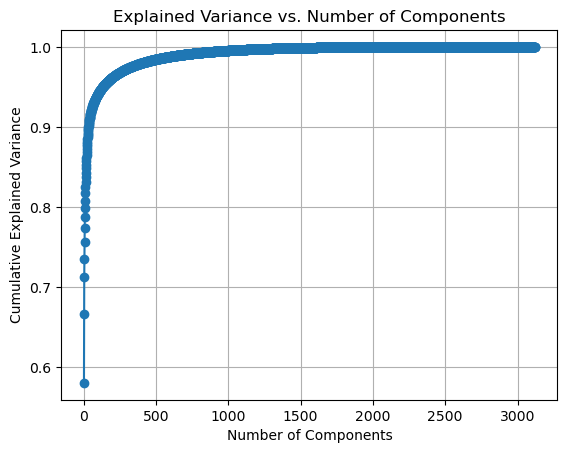

In [5]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(all_data_shuffled_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [6]:
n_components = 200
pca = PCA(n_components = n_components)
pca.fit(all_data_shuffled)
pca_tr = pca.fit_transform(all_data_shuffled_scaled)

## Model Analysis

#### Support Vector machines

Accuracy: 0.7612179487179487


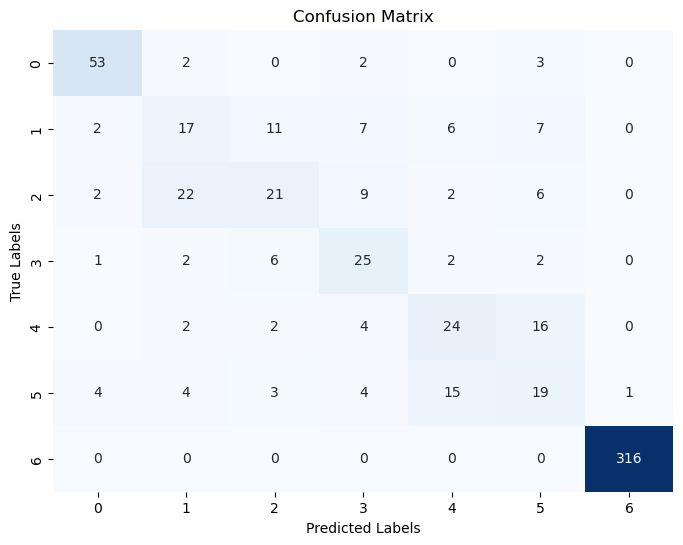

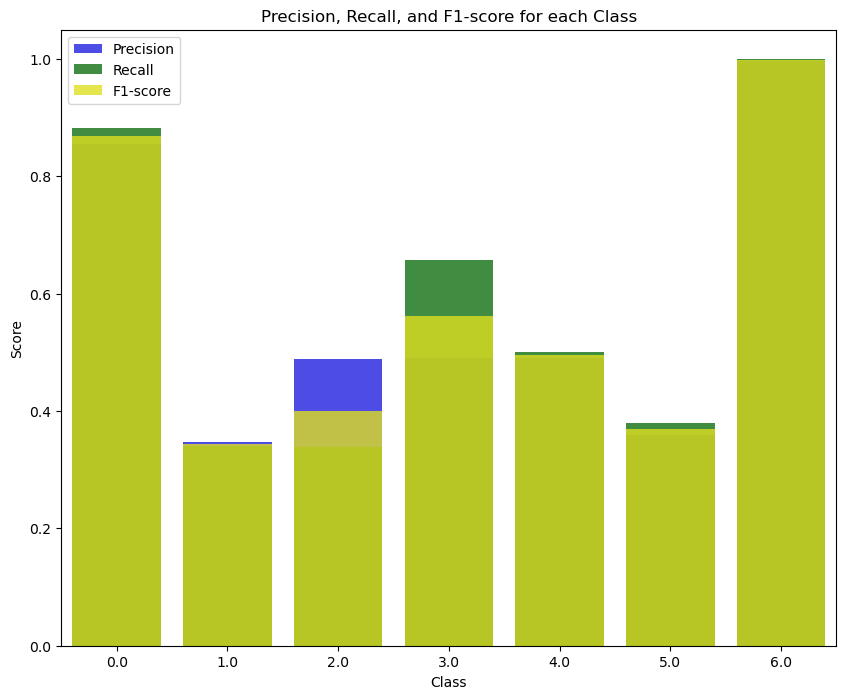

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87        60
         1.0       0.35      0.34      0.34        50
         2.0       0.49      0.34      0.40        62
         3.0       0.49      0.66      0.56        38
         4.0       0.49      0.50      0.49        48
         5.0       0.36      0.38      0.37        50
         6.0       1.00      1.00      1.00       316

    accuracy                           0.76       624
   macro avg       0.58      0.59      0.58       624
weighted avg       0.76      0.76      0.76       624



In [7]:
from sklearn.svm import SVC

model = SVC(kernel="rbf")
evaluate_model(model, all_data_shuffled_scaled, all_labels_shuffled)

Accuracy: 0.7564102564102564


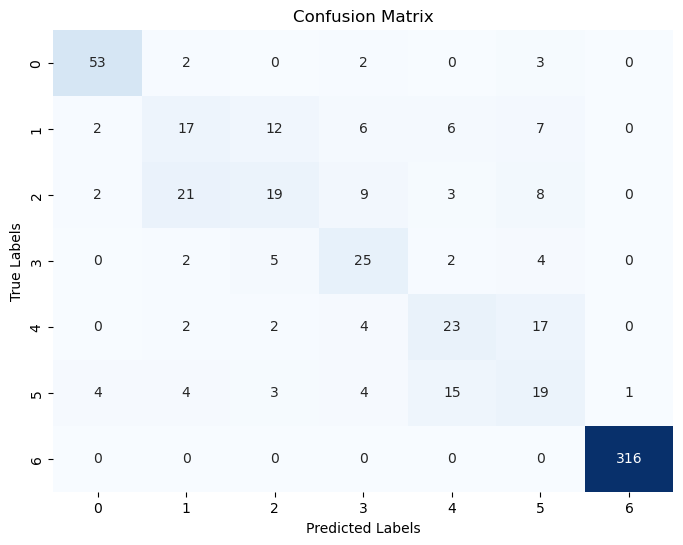

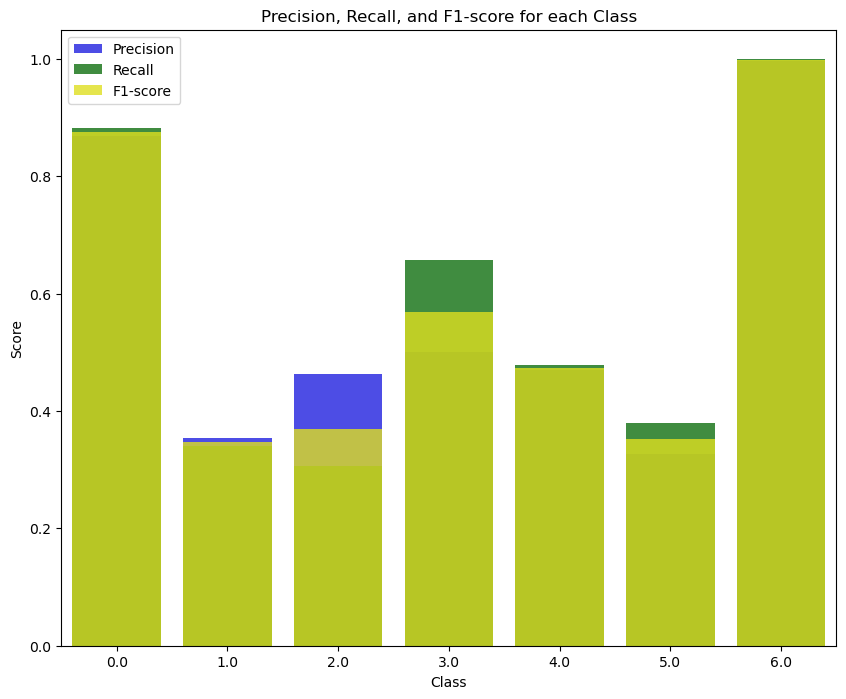

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88        60
         1.0       0.35      0.34      0.35        50
         2.0       0.46      0.31      0.37        62
         3.0       0.50      0.66      0.57        38
         4.0       0.47      0.48      0.47        48
         5.0       0.33      0.38      0.35        50
         6.0       1.00      1.00      1.00       316

    accuracy                           0.76       624
   macro avg       0.57      0.58      0.57       624
weighted avg       0.76      0.76      0.75       624



In [8]:
model = SVC(kernel="rbf")
evaluate_model(model, pca_tr, all_labels_shuffled)

#### Random Forest Model


Accuracy: 0.7596153846153846


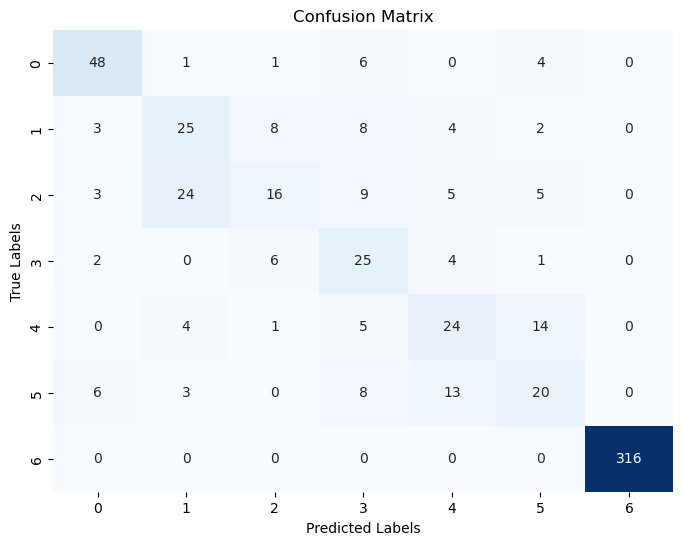

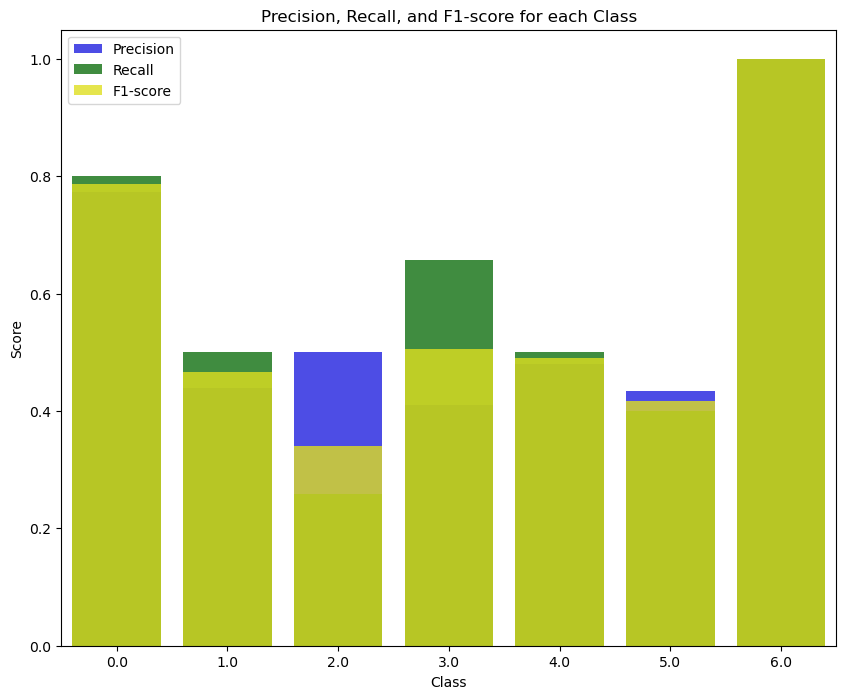

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.79        60
         1.0       0.44      0.50      0.47        50
         2.0       0.50      0.26      0.34        62
         3.0       0.41      0.66      0.51        38
         4.0       0.48      0.50      0.49        48
         5.0       0.43      0.40      0.42        50
         6.0       1.00      1.00      1.00       316

    accuracy                           0.76       624
   macro avg       0.58      0.59      0.57       624
weighted avg       0.76      0.76      0.76       624



In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### K nearest neighbor
**n_neighbors** : A common heuristic is to use the square root of the number of data points in the dataset as the k-value. fo this case k=√3000 ≈ 54.

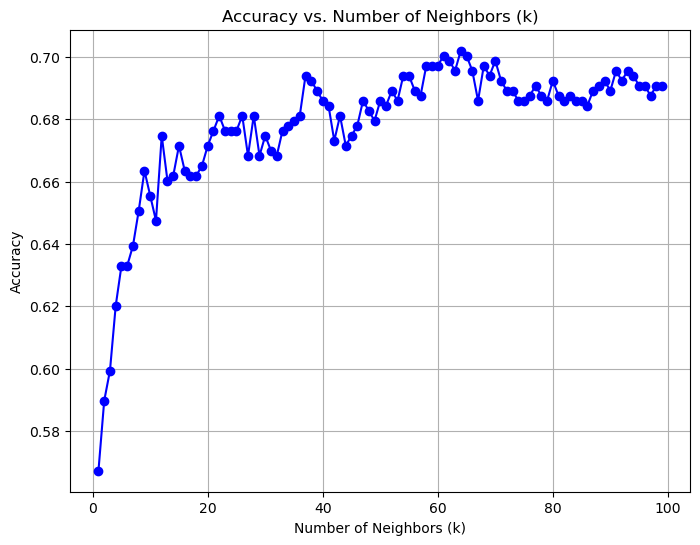

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tr, all_labels_shuffled, test_size=0.2, random_state=42)

# Initialize lists to store accuracy scores for different k values
k_values = list(range(1, 100))
accuracy_scores = []

# Loop through different k values
for k in k_values:
    # Create and fit the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


Accuracy: 0.6987179487179487


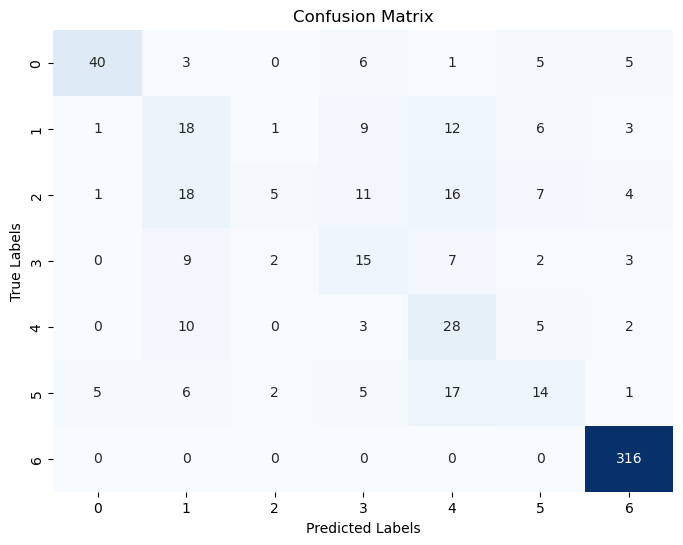

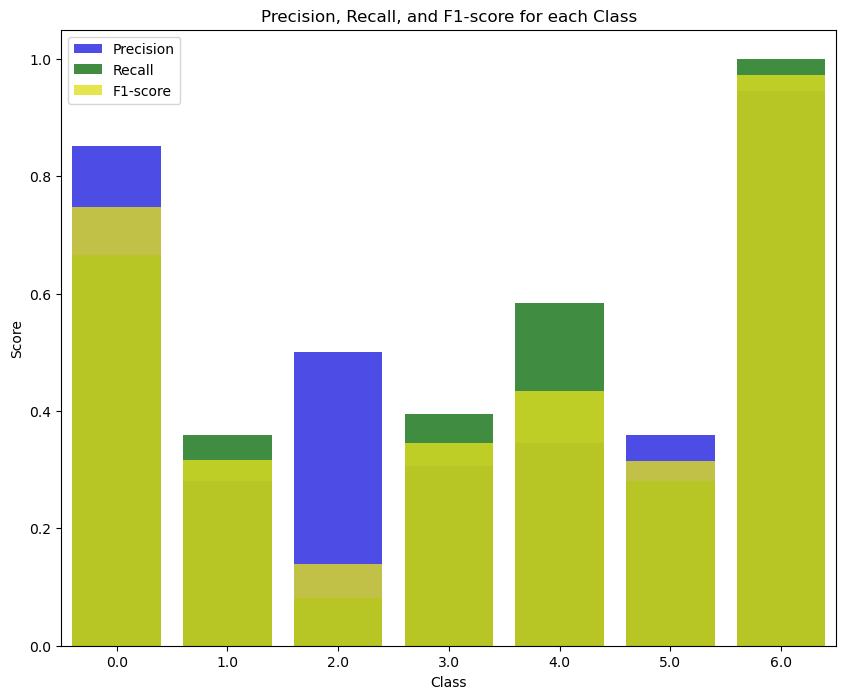

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.67      0.75        60
         1.0       0.28      0.36      0.32        50
         2.0       0.50      0.08      0.14        62
         3.0       0.31      0.39      0.34        38
         4.0       0.35      0.58      0.43        48
         5.0       0.36      0.28      0.31        50
         6.0       0.95      1.00      0.97       316

    accuracy                           0.70       624
   macro avg       0.51      0.48      0.47       624
weighted avg       0.71      0.70      0.68       624



In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors = 62)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### XGBoost

Accuracy: 0.7788461538461539


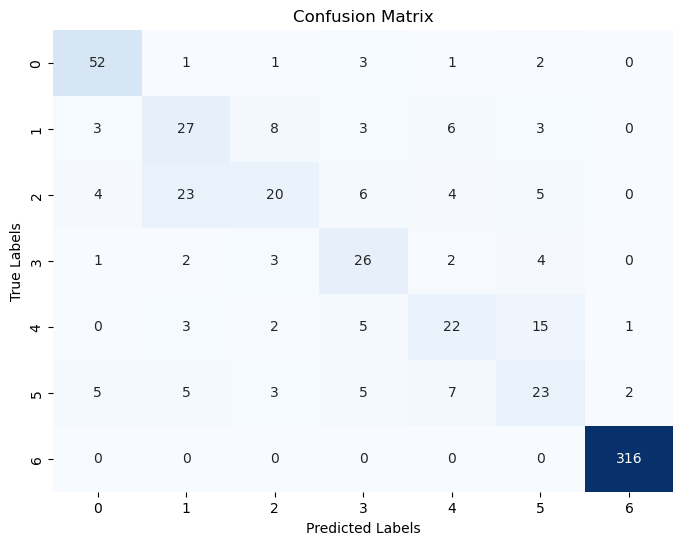

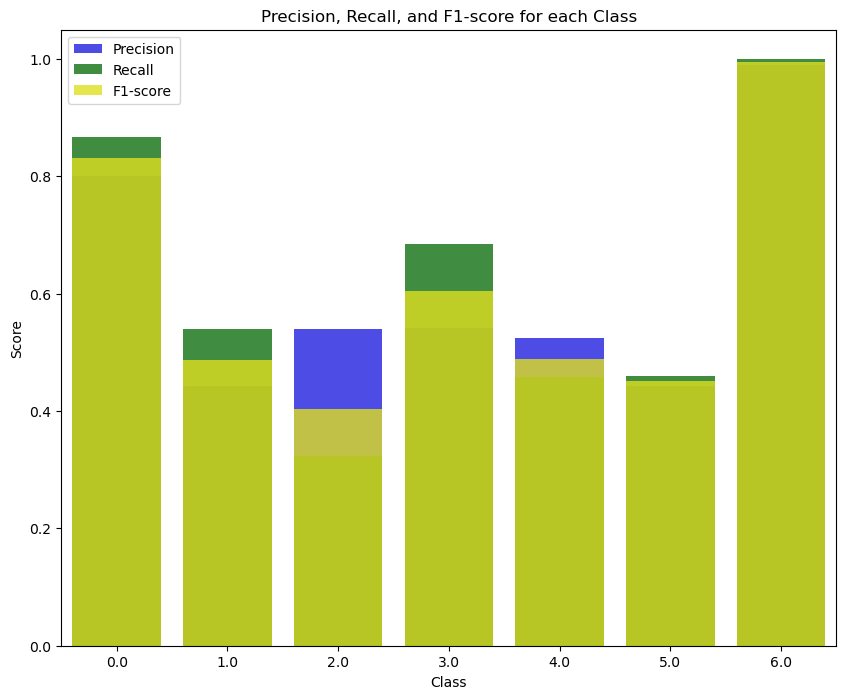

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83        60
         1.0       0.44      0.54      0.49        50
         2.0       0.54      0.32      0.40        62
         3.0       0.54      0.68      0.60        38
         4.0       0.52      0.46      0.49        48
         5.0       0.44      0.46      0.45        50
         6.0       0.99      1.00      1.00       316

    accuracy                           0.78       624
   macro avg       0.61      0.62      0.61       624
weighted avg       0.78      0.78      0.77       624



In [12]:
import xgboost as xgb
params = {
    'objective': 'multi:softmax',  # Multi-class classification objective
    'num_class': 7,                # Number of classes in the multi-class problem
    'eval_metric': 'mlogloss',     # Multiclass Logarithmic Loss
    'eta': 0.1,                    # Learning rate
    'max_depth': 3,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of columns when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

xgb_model = xgb.XGBClassifier(**params)
evaluate_model(xgb_model, pca_tr, all_labels_shuffled)